# Feature engineering with GeoPandas

Notebook is a part of article from blog. If you are interested in the whole content then take a look here: 

It is short example of feature engineering with GeoPandas. If we analyze spatial processes we cannot forget about spatial data! Sometimes we can get nice features for machine learning problems which were virtually hidden from us and from model.

Our task is divided into eight parts:

1. Load point data. Take a look into it.
2. Transform baseline dataset from simple DataFrame to GeoDataFrame.
3. Check a distribution of price in relation to categorical features.
4. Check a correlation between numerical values in the baseline dataset and price.
5. Create a new numerical feature - a distance to borough centroid from each apartment.
6. Create a new categorical features: school districts, fire divisions, police precints and health centers labels.
7. Check a distribution of price in relation to newly created categorical features.
8. Check a correlation between numerical values generated with spatial data and price.

## 1) Load point data. Take a look into it.


- import packages: `numpy`, `scipy`, `pandas`, `geopandas`, `matplotlib.pyplot`, `seaborn`, `from shapely.geometry import Point`,
- read `AB_NYC_2019.csv` file, set id as an index column,
- check **baseline** DataFrame,
- load other spatial datasets: Boroughs (`nybbwi_20d/nybbwi.shp`), fire divisions (`nyfd_20d/nyfd.shp`), police precints (`nypp_20d/nypp.shp`), school districts (`nysd_20d/nysd.shp`) and health centres (`nyhc_20d/nyhc.shp`). Plot them and check info about their structure.

In [1]:
# Import packages

import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mstats
from shapely.geometry import Point

In [2]:
# Set project constants

baseline_dataset = 'data/AB_NYC_2019.csv'
baseline_id_column = 'id'

boroughs = 'data/nybbwi_20d/nybbwi.shp'
fire_divs = 'data/nyfd_20d/nyfd.shp'
health_cns = 'data/nyhc_20d/nyhc.shp'
police_prs = 'data/nypp_20d/nypp.shp'
school_dis = 'data/nysd_20d/nysd.shp'

In [3]:
# Read NYC airbnb data and take a look into it

df = pd.read_csv(baseline_dataset,
                 index_col=baseline_id_column)
df.sample(3)

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,,,,,
4841431,Spacious 1BR By Prospect Park,24915465,Oded,Brooklyn,Prospect-Lefferts Gardens,40.66244,-73.95813,Entire home/apt,139,1,44,2016-05-08,0.80,1,0
12911110,"Sunny studio on UWS, steps to park",5317451,Kelly,Manhattan,Upper West Side,40.78397,-73.97063,Entire home/apt,90,8,1,2016-06-19,0.03,1,0
26280689,Artistic Room in walking distance to Central Park,197579052,Vlad,Manhattan,East Harlem,40.79778,-73.93921,Private room,80,1,60,2019-07-07,4.76,2,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48895 entries, 2539 to 36487245
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            48879 non-null  object 
 1   host_id                         48895 non-null  int64  
 2   host_name                       48874 non-null  object 
 3   neighbourhood_group             48895 non-null  object 
 4   neighbourhood                   48895 non-null  object 
 5   latitude                        48895 non-null  float64
 6   longitude                       48895 non-null  float64
 7   room_type                       48895 non-null  object 
 8   price                           48895 non-null  int64  
 9   minimum_nights                  48895 non-null  int64  
 10  number_of_reviews               48895 non-null  int64  
 11  last_review                     38843 non-null  object 
 12  reviews_per_month         

In [5]:
df.describe()

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [6]:
# Spatial data sources

gdf_boroughs = gpd.read_file(boroughs)
gdf_fire_divs = gpd.read_file(fire_divs)
gdf_police_prs = gpd.read_file(police_prs)
gdf_school_dis = gpd.read_file(school_dis)
gdf_health_cns = gpd.read_file(health_cns)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   BoroCode    5 non-null      int64   
 1   BoroName    5 non-null      object  
 2   Shape_Leng  5 non-null      float64 
 3   Shape_Area  5 non-null      float64 
 4   geometry    5 non-null      geometry
dtypes: float64(2), geometry(1), int64(1), object(1)
memory usage: 328.0+ bytes
None
epsg:2263


<AxesSubplot:>

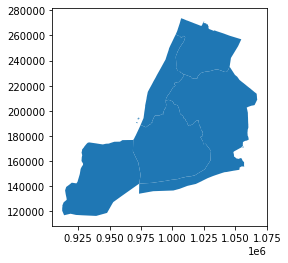

In [7]:
# Initial check of spatial datasets

print(gdf_boroughs.info())
print(gdf_boroughs.crs)
gdf_boroughs.plot()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   FireDiv     9 non-null      int64   
 1   Shape_Leng  9 non-null      float64 
 2   Shape_Area  9 non-null      float64 
 3   geometry    9 non-null      geometry
dtypes: float64(2), geometry(1), int64(1)
memory usage: 416.0 bytes
None
epsg:2263


<AxesSubplot:>

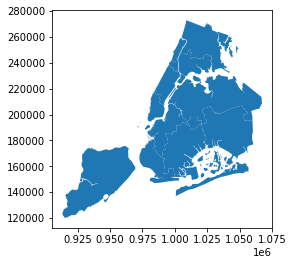

In [8]:
print(gdf_fire_divs.info())
print(gdf_fire_divs.crs)
gdf_fire_divs.plot()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Precinct    77 non-null     int64   
 1   Shape_Leng  77 non-null     float64 
 2   Shape_Area  77 non-null     float64 
 3   geometry    77 non-null     geometry
dtypes: float64(2), geometry(1), int64(1)
memory usage: 2.5 KB
None
epsg:2263


<AxesSubplot:>

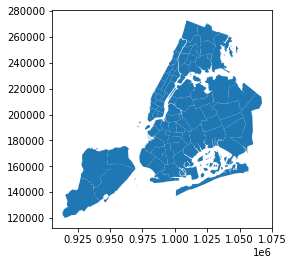

In [9]:
print(gdf_police_prs.info())
print(gdf_police_prs.crs)
gdf_police_prs.plot()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   SchoolDist  33 non-null     int64   
 1   Shape_Leng  33 non-null     float64 
 2   Shape_Area  33 non-null     float64 
 3   geometry    33 non-null     geometry
dtypes: float64(2), geometry(1), int64(1)
memory usage: 1.2 KB
None
epsg:2263


<AxesSubplot:>

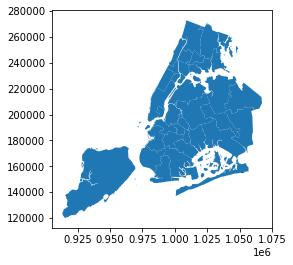

In [10]:
print(gdf_school_dis.info())
print(gdf_school_dis.crs)
gdf_school_dis.plot()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   BoroCode    30 non-null     int64   
 1   BoroName    30 non-null     object  
 2   HCentDist   30 non-null     int64   
 3   Shape_Leng  30 non-null     float64 
 4   Shape_Area  30 non-null     float64 
 5   geometry    30 non-null     geometry
dtypes: float64(2), geometry(1), int64(2), object(1)
memory usage: 1.5+ KB
None
epsg:2263


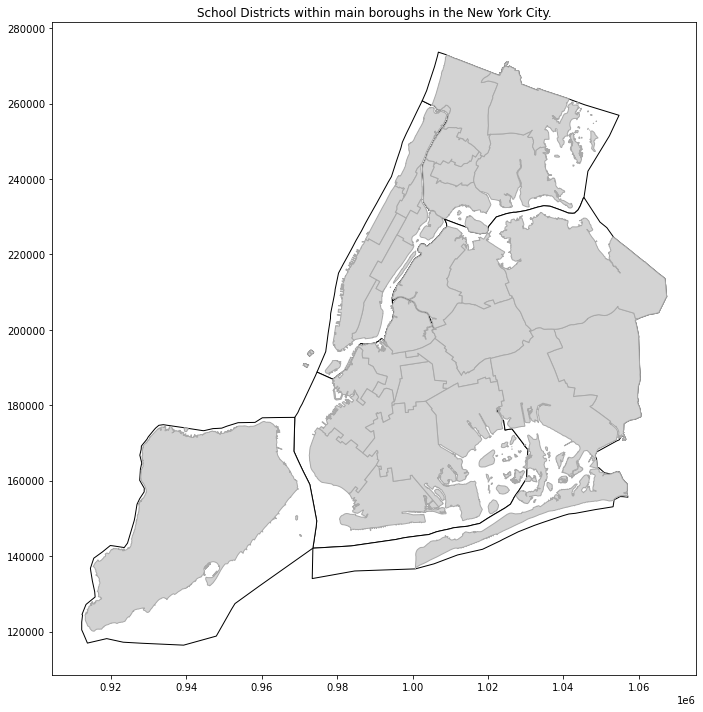

In [11]:
print(gdf_health_cns.info())
print(gdf_health_cns.crs)
base = gdf_boroughs.plot(color='white', edgecolor='black', figsize=(12, 12))
gdf_health_cns.plot(ax=base, color='lightgray', edgecolor='darkgray');
plt.title('School Districts within main boroughs in the New York City.');

## 2) Transform baseline dataset from simple DataFrame to GeoDataFrame.

- Create column with `Point` geometry, and drop unwanted columns. Leave `'neighbourhood_group', 'neighbourhood', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'geometry'` columns,
- set *crs* od *GeoDataFrame* to **EPSG:4326**,
- check if all datasets have the same *crs*,
- transform *crs* of datasets if it's not the same for all datasets.

In [12]:
# Transform geometry

def lat_lon_to_point(dataframe, lon_col='longitude', lat_col='latitude'):
    """Function transform longitude and latitude coordinates into GeoSeries.
    
    INPUT:
    
    :param dataframe: DataFrame to be transformed,
    :param lon_col: (str) longitude column name, default is 'longitude',
    :param lat_col: (str) latitude column name, default is 'latitude'.
    
    OUTPUT:
    
    :return: (GeoPandas GeoSeries object)
    """

    geometry = dataframe.apply(lambda x: Point([x[lon_col], x[lat_col]]), axis=1)
    geoseries = gpd.GeoSeries(geometry)
    geoseries.name = 'geometry'
    
    return geoseries

In [13]:
geometry = lat_lon_to_point(df)
gdf = df.join(geometry)
print(gdf.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48895 entries, 2539 to 36487245
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   name                            48879 non-null  object  
 1   host_id                         48895 non-null  int64   
 2   host_name                       48874 non-null  object  
 3   neighbourhood_group             48895 non-null  object  
 4   neighbourhood                   48895 non-null  object  
 5   latitude                        48895 non-null  float64 
 6   longitude                       48895 non-null  float64 
 7   room_type                       48895 non-null  object  
 8   price                           48895 non-null  int64   
 9   minimum_nights                  48895 non-null  int64   
 10  number_of_reviews               48895 non-null  int64   
 11  last_review                     38843 non-null  object  
 12  reviews_per_

<AxesSubplot:>

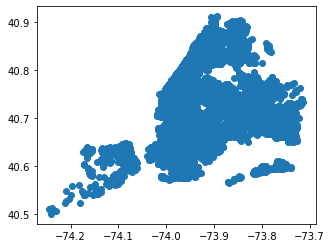

In [14]:
# GeoSeries may be plotted

geometry.plot()

In [15]:
# But pandas won't allow us to do the same

gdf['geometry'].plot()

TypeError: no numeric data to plot

In [16]:
# Leave only wanted columns

gdf = gdf[['neighbourhood_group', 'neighbourhood', 'room_type', 'price', 'minimum_nights',
           'number_of_reviews','reviews_per_month', 'calculated_host_listings_count', 'geometry']]

# Drop NaNs
gdf = gdf.dropna(axis=0)

# Drop duplicates
gdf = gdf.drop_duplicates()

<AxesSubplot:>

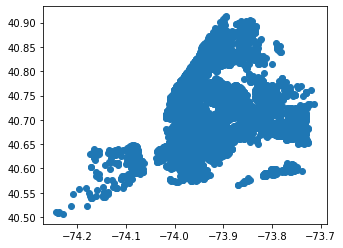

In [17]:
# Transform dataframe into geodataframe

gdf = gpd.GeoDataFrame(gdf, geometry='geometry', crs='EPSG:4326')
gdf.plot()

In [18]:
# Transform CRS of the baseline GeoDataFrame

gdf.to_crs(crs=gdf_boroughs.crs, inplace=True)

# Check if all crs are the same

print(gdf.crs == gdf_boroughs.crs == gdf_fire_divs.crs == \
     gdf_health_cns.crs == gdf_police_prs.crs == gdf_school_dis.crs)

True


## 3) Check a distribution of price in relation to categorical features

In [19]:
def print_nunique(series):
    text = f'Data contains {series.nunique()} unique categories'
    print(text)

# neighbourhood_group

print_nunique(gdf['neighbourhood_group'])

Data contains 5 unique categories


Text(0.5, 1.0, 'Distribution of price in relation to categorical variables: Boroughs.')

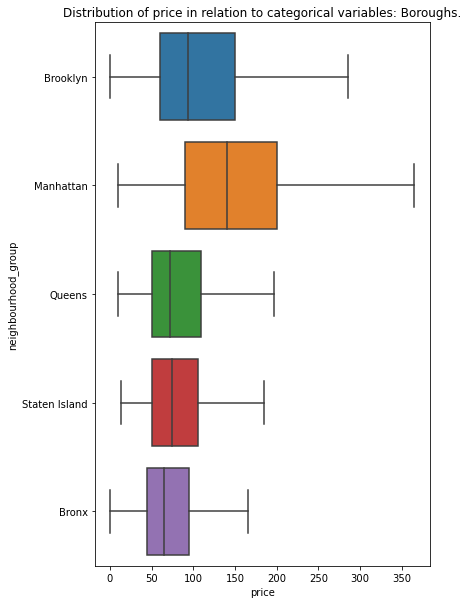

In [20]:
plt.figure(figsize=(6, 10))
sns.boxplot(y='neighbourhood_group', x='price',
            data=gdf, orient='h', showfliers=False)
plt.title('Distribution of price in relation to categorical variables: Boroughs.')

In [21]:
# neighbourhoods

print_nunique(gdf['neighbourhood'])

Data contains 218 unique categories


In [75]:
# There are too many values to plot them all...

def categorical_distributions(dataframe, categorical_column, numerical_column, dropna=True):
    """
    Function groups data by unique categories and check basic information about
    data distribution per category.

    INPUT:

    :param dataframe: (DataFrame or GeoDataFrame),
    :param categorical_column: (str),
    :param numerical_column: (str),
    :param dropna: (bool) default=True, drops rows with NaN's as index.

    OUTPUT:

    :return: (DataFrame) DataFrame where index represents unique category
        and columns represents: count, mean, median, variance, 1st quantile,
        3rd quantile, skewness and kurtosis.
    """

    cat_df = dataframe[[categorical_column, numerical_column]].copy()

    output_df = pd.DataFrame(index=cat_df[categorical_column].unique())

    # Count
    output_df['count'] = cat_df.groupby(categorical_column).count()
    
    # Mean
    output_df['mean'] = cat_df.groupby(categorical_column).mean()

    # Variance
    output_df['var'] = cat_df.groupby(categorical_column).std()

    # Median
    output_df['median'] = cat_df.groupby(categorical_column).median()

    # 1st quantile
    output_df['1st_quantile'] = cat_df.groupby(categorical_column).quantile(0.25)

    # 3rd quantile
    output_df['3rd_quantile'] = cat_df.groupby(categorical_column).quantile(0.75)

    # skewness
    output_df['skew'] = cat_df.groupby(categorical_column).skew()

    # kurtosis
    try:
        output_df['kurt'] = cat_df.groupby(categorical_column).apply(pd.Series.kurt)
    except ValueError:
        output_df['kurt'] = cat_df.groupby(categorical_column).apply(pd.Series.kurt)[numerical_column]
        
    # Dropna
    
    if dropna:
        output_df = output_df[~output_df.index.isna()]

    return output_df

In [76]:
neigh_dists = categorical_distributions(gdf, 'neighbourhood', 'price')

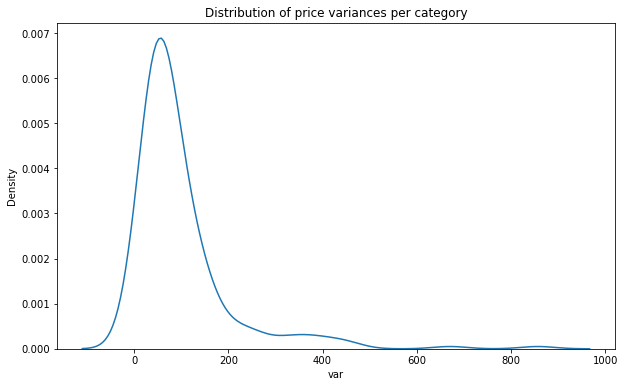

In [77]:
# Check distribution of variances

plt.figure(figsize=(10, 6))
sns.kdeplot(neigh_dists['var']);
plt.title('Distribution of price variances per category');

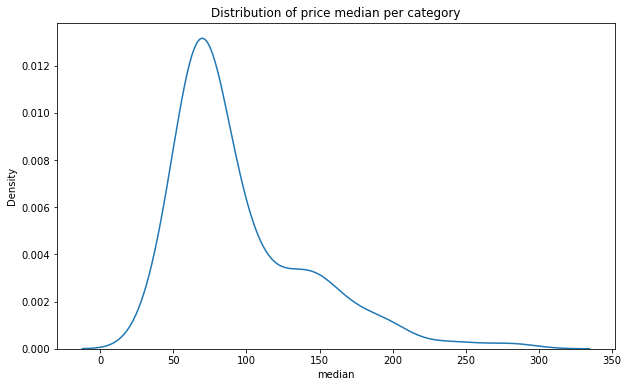

In [78]:
# Check distribution of median values

plt.figure(figsize=(10, 6))
sns.kdeplot(neigh_dists['median']);
plt.title('Distribution of price median per category');

## 4) Check a correlation between numerical values in the baseline dataset and price

In [63]:
gdf.corrwith(gdf['price'])

price                             1.000000
minimum_nights                    0.025506
number_of_reviews                -0.035938
reviews_per_month                -0.030608
calculated_host_listings_count    0.052903
cdist_Manhattan                  -0.146215
cdist_Bronx                       0.011227
cdist_Brooklyn                    0.011877
cdist_Queens                      0.096206
cdist_Staten Island              -0.058386
dtype: float64

## 5) Create a new numerical feature - a distance to borough centroid from each apartment

Our numerical predictors are very weak. Therefore we create new one, hopefully better than those provided with dataset.

In [64]:
# Get borough centroids

gdf_boroughs['centroids'] = gdf_boroughs.centroid

In [65]:
# Create n numerical columns
# n = number of boroughs

for bname in gdf_boroughs['BoroName'].unique():
    district_name = 'cdist_' + bname
    cent = gdf_boroughs[gdf_boroughs['BoroName'] == bname]['centroids'].values[0]
    gdf[district_name] = gdf['geometry'].distance(cent)

In [66]:
gdf.columns

Index(['neighbourhood_group', 'neighbourhood', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'geometry', 'cdist_Manhattan',
       'cdist_Bronx', 'cdist_Brooklyn', 'cdist_Queens', 'cdist_Staten Island'],
      dtype='object')

In [67]:
gdf[['cdist_Manhattan', 'cdist_Bronx', 'cdist_Brooklyn', 'cdist_Queens', 'cdist_Staten Island']].sample(3)

,cdist_Manhattan,cdist_Bronx,cdist_Brooklyn,cdist_Queens,cdist_Staten Island
id,,,,,
26424667,4718.196818,43721.714587,46721.829886,45085.038879,86889.096115
16650612,5791.289946,48085.519333,48517.819230,51174.184221,83881.960094
22166900,19231.433849,58579.441430,33296.789585,44160.885374,71721.356015


## 6) Create a new categorical features: school districts, fire divisions, police precincts and health centers labels

In [68]:
# Make a copy of dataframe before any join

ext_gdf = gdf.copy()

In [69]:
# Join Fire Divisions

ext_gdf = gpd.sjoin(ext_gdf, gdf_fire_divs[['geometry', 'FireDiv']], how='left', op='within')
ext_gdf.drop('index_right', axis=1, inplace=True)

In [70]:
# Join Health Centers

ext_gdf = gpd.sjoin(ext_gdf, gdf_health_cns[['geometry', 'HCentDist']], how='left', op='within')
ext_gdf.drop('index_right', axis=1, inplace=True)

In [71]:
# Join Police Precincts

ext_gdf = gpd.sjoin(ext_gdf, gdf_police_prs[['geometry', 'Precinct']], how='left', op='within')
ext_gdf.drop('index_right', axis=1, inplace=True)

In [72]:
# Join School Districts

ext_gdf = gpd.sjoin(ext_gdf, gdf_school_dis[['geometry', 'SchoolDist']], how='left', op='within')
ext_gdf.drop('index_right', axis=1, inplace=True)

## 7) Check a distribution of price in relation to newly created categorical features

In [79]:
categorical_columns = ['FireDiv', 'HCentDist', 'Precinct', 'SchoolDist']
categorical_dists = {}

for col in categorical_columns:
    categorical_dists[col] = categorical_distributions(ext_gdf, col, 'price')

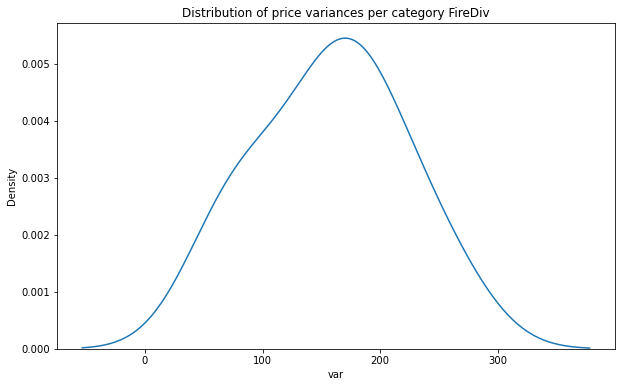

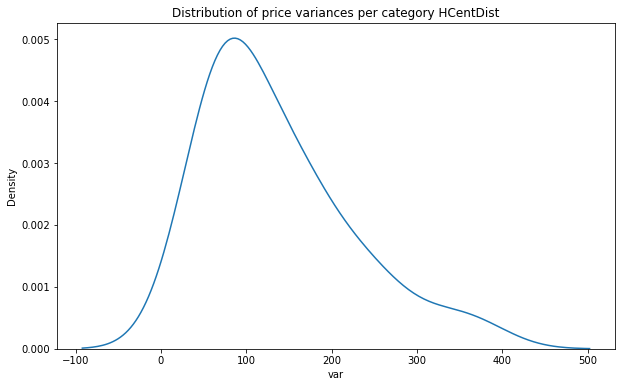

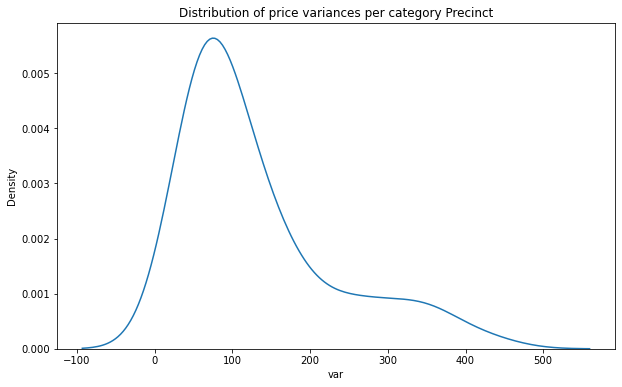

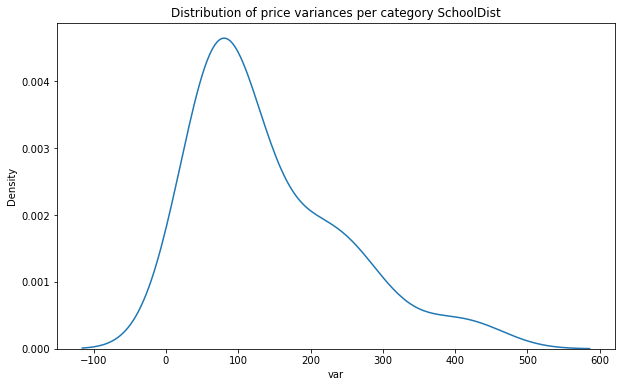

In [81]:
for cat in categorical_columns:
    # Check distribution of variances

    plt.figure(figsize=(10, 6))
    sns.kdeplot(categorical_dists[cat]['var']);
    plt.title(f'Distribution of price variances per category {cat}');

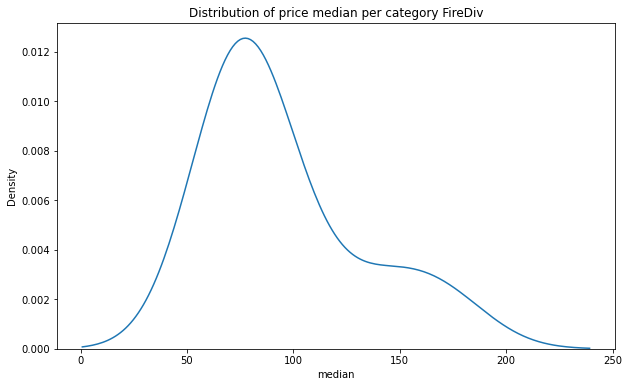

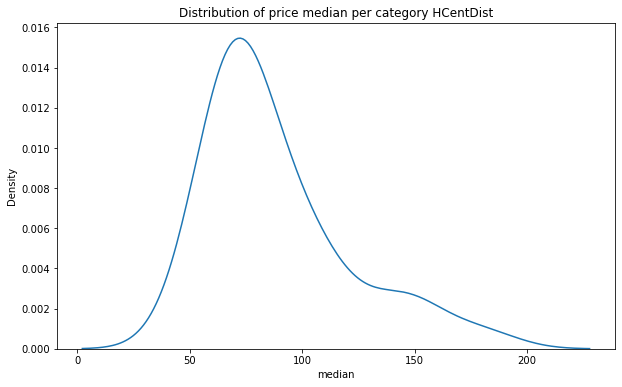

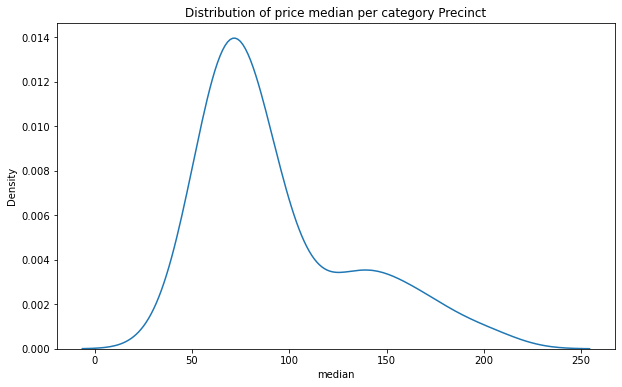

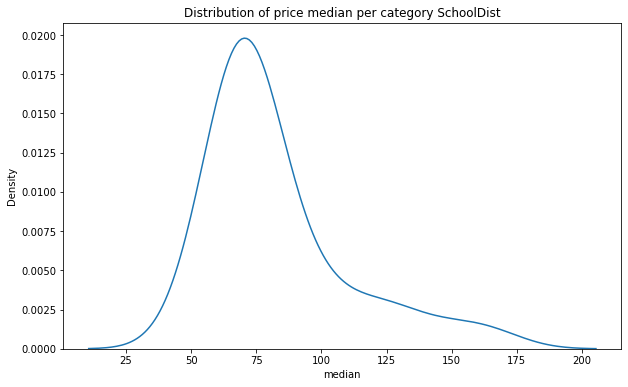

In [82]:
for cat in categorical_columns:
    # Check distribution of variances

    plt.figure(figsize=(10, 6))
    sns.kdeplot(categorical_dists[cat]['median']);
    plt.title(f'Distribution of price median per category {cat}');

## 8) Check a correlation between numerical values generated with spatial data and price

In [91]:
# Check corr with numerical

np.abs(ext_gdf.corrwith(ext_gdf['price'])).sort_values(ascending=False)

price                             1.000000
FireDiv                           0.186965
SchoolDist                        0.182299
Precinct                          0.174037
HCentDist                         0.160042
cdist_Manhattan                   0.146215
cdist_Queens                      0.096206
cdist_Staten Island               0.058386
calculated_host_listings_count    0.052903
number_of_reviews                 0.035938
reviews_per_month                 0.030608
minimum_nights                    0.025506
cdist_Brooklyn                    0.011877
cdist_Bronx                       0.011227
dtype: float64

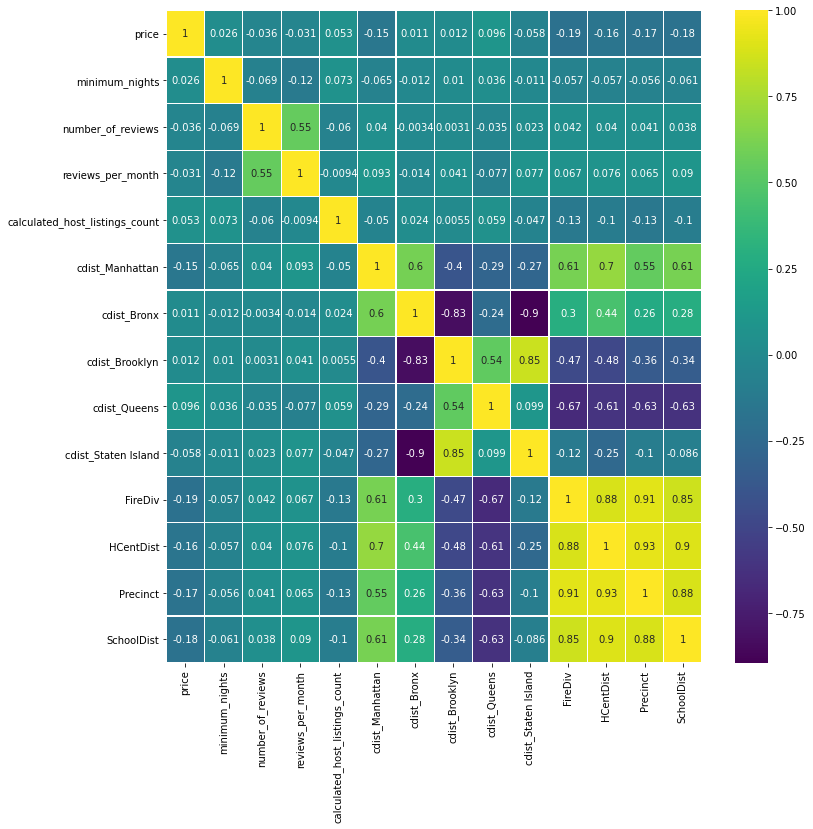

In [95]:
plt.figure(figsize=(12, 12))
sns.heatmap(ext_gdf.corr(), annot=True, linewidths=0.2, cmap='viridis')
plt.show()